In [1]:
import jax
import numpy as onp
from jax import numpy as np
from jax import vmap, jit
from jax.tree_util import tree_map


from functools import partial
from typing import Callable


import matplotlib as mpl
from matplotlib import animation
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from ml_collections import config_dict


from typing import Tuple, Dict, Callable
import functools
import dill as pickle


from tqdm.notebook import tqdm
import time


import sys
sys.path.append('../../py')
import common.systems as systems
import launchers.learn as learn

%matplotlib inline

mpl.rcParams['axes.grid']  = True
mpl.rcParams['axes.grid.which']  = 'both'
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['ytick.minor.visible']  = True
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = '0.8'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['figure.titlesize'] = 17.5
mpl.rcParams['font.size'] = 17.5
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['figure.dpi'] = 125
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Load data

In [2]:
## shifted system, higher resolution
# base_folder = '/scratch/nb3397/results/strato/lowd_vicsek/6_21_24'
# output_name = 'debug_0_4'
# output_name = 'debug_0_6'
# output_name = '6_21_rescale_g_final'

## not-scaled
# base_folder = '/scratch/nb3397/results/strato/vicsek/7_10_24'
# # output_name = '7_8_24_mlp_no_cutoff_test_bigbatch_0_1'
# # output_name = '7_9_24_mlp_no_cutoff_nonsmooth_0_5'
# output_name = '7_10_24_mlp_norescale_0_5'

## not-scaled, low-d architecture
base_folder = '/scratch/nb3397/results/strato/vicsek/9_7_24'
output_name = '9_7_24_N2_production_0_18'


## load the data
data = pickle.load(open(f'{base_folder}/{output_name}.npy', 'rb'))

In [3]:
params = data['params']
ema_params = data['ema_params']
xgs = data['xgs']
xs, gs = np.split(xgs, 2, axis=1)
cfg = data['cfg']
copied_cfg = config_dict.ConfigDict(cfg)


try:
    cfg.share_encoder
except:
    copied_cfg.share_encoder = 0
    copied_cfg.n_neurons_encoder_out = cfg.n_neurons

try:
    cfg.sum_pool
except:
    copied_cfg.sum_pool = 0

try:
    cfg.use_residual
except:
    copied_cfg.use_residual = 0

try:
    cfg.use_layernorm
except:
    copied_cfg.use_layernorm = 0

try:
    cfg.rescale_type
except:
    copied_cfg.rescale_type = 'g'

try:
    cfg.k
except:
    copied_cfg.k = 1.0

try:
    cfg.system.rescale_type
except:
    copied_cfg.system = systems.Vicsek(
            cfg.dt_online,
            cfg.r,
            cfg.v0,
            cfg.gamma,
            cfg.width,
            cfg.eps,
            cfg.d,
            cfg.N,
            cfg.beta,
            cfg.k,
            cfg.A,
            cfg.gstar_mag,
            copied_cfg.rescale_type,
        )


cfg = copied_cfg
net, map_net = learn.construct_network(cfg)


# a bit unsafe
learn.cfg = cfg
learn.net = net
learn.map_net = map_net

In [4]:
# figure_output = f'{base_folder}/figs/9_4_24'
# figure_output = f'{base_folder}/figs/9_7_24'
figure_output = f'{base_folder}/figs/9_8_24'

# Entropy plots

In [8]:
def make_reduced_entropy_density_plot(
    params: Dict,
    npts: int,
    nbatches: int,
    compute_histogram: bool,
    clip_quantile: float,
    norm_power: float,
    g_clip_fac: float,
    shift_xs: bool,
    plot_square: bool,
    drop_cbar_labels: bool,
    plot_vx: bool,
    output_name: str,
) -> None:
    ### compute quantities needed for plotting
    batch_size = cfg.ntrajs // nbatches
    xs = onp.zeros((cfg.ntrajs, 2, 1))
    gs = onp.zeros((cfg.ntrajs, 2, 1))
    vxs = onp.zeros((cfg.ntrajs, 2, 1))
    vgs = onp.zeros((cfg.ntrajs, 2, 1))
    div_vxs = onp.zeros((cfg.ntrajs, 2))
    div_vgs = onp.zeros((cfg.ntrajs, 2))
    for curr_batch in range(nbatches):
        lb = batch_size*curr_batch
        ub = lb + batch_size

        (
            xs[lb:ub],
            gs[lb:ub],
            vxs[lb:ub],
            vgs[lb:ub],
            _,
            _,
            div_vxs[lb:ub],
            div_vgs[lb:ub],
            _,
            _
        ) = learn.map_oned_output_info(xgs[lb:ub], params)

    ## compute displacement coordinates (all of shape [bs])
    gs = np.squeeze(gs[:, 0] - gs[:, 1])
    if shift_xs:
        xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]) + cfg.width)
        gs = -gs
    else:
        xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]))
    vxs = np.squeeze(vxs[:, 0] - vxs[:, 1])
    vgs = np.squeeze(vgs[:, 0] - vgs[:, 1])


    # note the plus with divergences -- this follows because
    # \nabla_{g^2} = -\nabla_{g}
    div_vxs = np.squeeze(div_vxs[:, 0] + div_vxs[:, 1])
    div_vgs = np.squeeze(div_vgs[:, 0] + div_vgs[:, 1])

    # compute full divergences
    div_vs = div_vxs + div_vgs

    # compute norms
    gdot_mags = np.abs(vgs)
    xdot_mags = np.abs(vxs)
        
    ### grid quantities
    pointwise_quantities = [gdot_mags, xdot_mags, div_vs]
    ncols = len(pointwise_quantities)
    gridded_quantities       = onp.zeros((ncols, npts, npts))
    xgrid_plots, ggrid_plots = onp.zeros((ncols, npts, npts)), onp.zeros((ncols, npts, npts))
    for jj in range(ncols):
        # sum quantities in each grid cell
        gridded_quantities[jj], xedges, gedges = np.histogram2d(
            xs, gs, weights=pointwise_quantities[jj], bins=npts, density=False
        )

        # remove bins with very few samples (noisy estimate) and compute the average per bin
        multiplicity = onp.array(np.histogram2d(xs, gs, bins=(xedges, gedges), density=False)[0])
        inds = (multiplicity <= (0.01*np.mean(multiplicity)))
        multiplicity[inds] = 1.0
        gridded_quantities[jj][inds] = 0.0
        gridded_quantities[jj] /= multiplicity

        # scale by the density (fix off-by-constant issue with previous paper)
        if compute_histogram:
            density = onp.array(np.histogram2d(xs, gs, bins=(xedges, gedges), density=True)[0])
            gridded_quantities[jj] *= density

        curr_xgrid, curr_ggrid = np.meshgrid(xedges, gedges, indexing='ij')
        xgrid_plots[jj] = curr_xgrid[:-1, :-1] + 0.5*np.diff(xedges)[:, None]
        ggrid_plots[jj] = curr_ggrid[:-1, :-1] + 0.5*np.diff(gedges)[None, :]

    # square the outputs
    if plot_square:
        gridded_quantities[0] = gridded_quantities[0]**2
        gridded_quantities[1] = gridded_quantities[1]**2


    ###### main entropy figure
    # common plot parameters
    plt.close('all')
    sns.set_palette('deep')
    fw        = 8.0
    fh        = 8.0
    fraction  = 0.2
    shrink    = 0.5
    fontsize  = 28


    min_g, max_g = g_clip_fac*gs.min(), g_clip_fac*gs.max()
    min_g        = min(min_g, -max_g)
    max_g        = max(-min_g, max_g)
    min_x, max_x = -cfg.width, cfg.width


    # individual panels
    if not compute_histogram:
        if plot_square or (norm_power == 2 and drop_cbar_labels):
            titles = [r"$\dot{s}_{\text{tot}}$", r"$|v_x|^2$",  r"$\dot{s}_{\text{sys}}$"]
        else:
            titles = [r"$|v_g|$", r"$|v_x|$",  r"$\dot{s}_{\text{sys}}$"]
    else:
        if plot_square or (norm_power == 2 and drop_cbar_labels):
            titles = [r"$\dot{s}_{\text{tot}}\cdot\rho$", r"$|v_x|^2\cdot\rho$", r"$\dot{s}_{\text{sys}}\cdot\rho$"]
        else:
            titles = [r"$|v_g|\cdot\rho$", r"$|v_x|\cdot\rho$", r"$\dot{s}_{\text{sys}}\cdot\rho$"]

    cmaps = [sns.color_palette('mako', as_cmap=True), sns.color_palette('mako', as_cmap=True), sns.color_palette('icefire', as_cmap=True)]

    # just remove the corresponding list and array elements
    if not plot_vx:
        del titles[1]
        del cmaps[1]        
        gridded_quantities = np.delete(gridded_quantities, 1, axis=0)
        xgrid_plots = np.delete(xgrid_plots, 1, axis=0)
        ggrid_plots = np.delete(ggrid_plots, 1, axis=0)

    ncols = len(titles)
    fig, axs = plt.subplots(
        nrows=1, ncols=ncols, figsize=(fw*ncols, fh),
        sharex=False, sharey=True, constrained_layout=True
    )

    for ax in axs.ravel():
        ax.set_xlim([min_x, max_x])
        ax.set_ylim([min_g, max_g])
        ax.set_xticks([     -1,      -1/2, 0,      1/2,      1])
        ax.grid(which='both', axis='both', color='0.9', alpha=0.1)
        ax.tick_params(which='both', width=0, length=0, labelsize=fontsize)

        for spine in ax.spines.values():
            spine.set_edgecolor('grey')


    # do the plotting
    for jj in range(ncols):
        print(f'Starting {titles[jj]}')
        title = titles[jj]
        grid_values = gridded_quantities[jj]
        ax = axs[jj]

        ## clip the values to quantile to avoid washout
        vmin = onp.quantile(grid_values, q=clip_quantile)
        vmax = onp.quantile(grid_values, q=(1-clip_quantile))

        if vmin < 0:
            vmin = min(vmin, -vmax)
            vmax = max(-vmin, vmax)

        # rescale to [0, 1] or [-1, 1]
        if drop_cbar_labels:
            grid_values = (grid_values - vmin) / (vmax - vmin)
            if vmin >= 0:
                cbar_min, cbar_max = 0, 1
            else:
                grid_values *= 2
                grid_values -= 1
                cbar_min, cbar_max = -1, 1
        else:
            cbar_min, cbar_max = vmin, vmax

        # symmetrize
        if vmin < 0 or norm_power == 1:
            norm = mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max, clip=True)
        else:
            norm = mpl.colors.PowerNorm(gamma=norm_power, vmin=cbar_min, vmax=cbar_max, clip=True)

        mappable = mpl.cm.ScalarMappable(cmap=cmaps[jj], norm=norm)
        mappable.set_array([])
        ax.set_facecolor(mappable.to_rgba(0.0))
        ctr  = ax.contourf(xgrid_plots[jj], ggrid_plots[jj], grid_values, cmap=cmaps[jj], norm=norm, levels=100)
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmaps[jj]), 
            ax=ax, fraction=fraction, shrink=shrink, orientation='horizontal'
        )
        cbar.ax.tick_params(which='both', labelsize=fontsize, width=0, length=0)
        cbar.ax.set_xlabel(title, fontsize=fontsize)
        cbar.outline.set_edgecolor('grey')

        # fix strange aliasing artifact
        for c in ctr.collections:
            c.set_edgecolor("face")
            c.set_rasterized(True)

        ax.set_xlabel(r"$x$", fontsize=fontsize)
        if jj == 0:
            ax.set_ylabel(r"$g / v_0$", fontsize=fontsize)


    if output_name != '':
        fig.patch.set_facecolor('k')
        fig.patch.set_alpha(0.0)
        plt.savefig(output_name, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

### Scatter plot

Starting $|v_g|$


/state/partition1/job-50776795/ipykernel_772113/2465197830.py:198: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:


Starting $\dot{s}_{\text{sys}}$


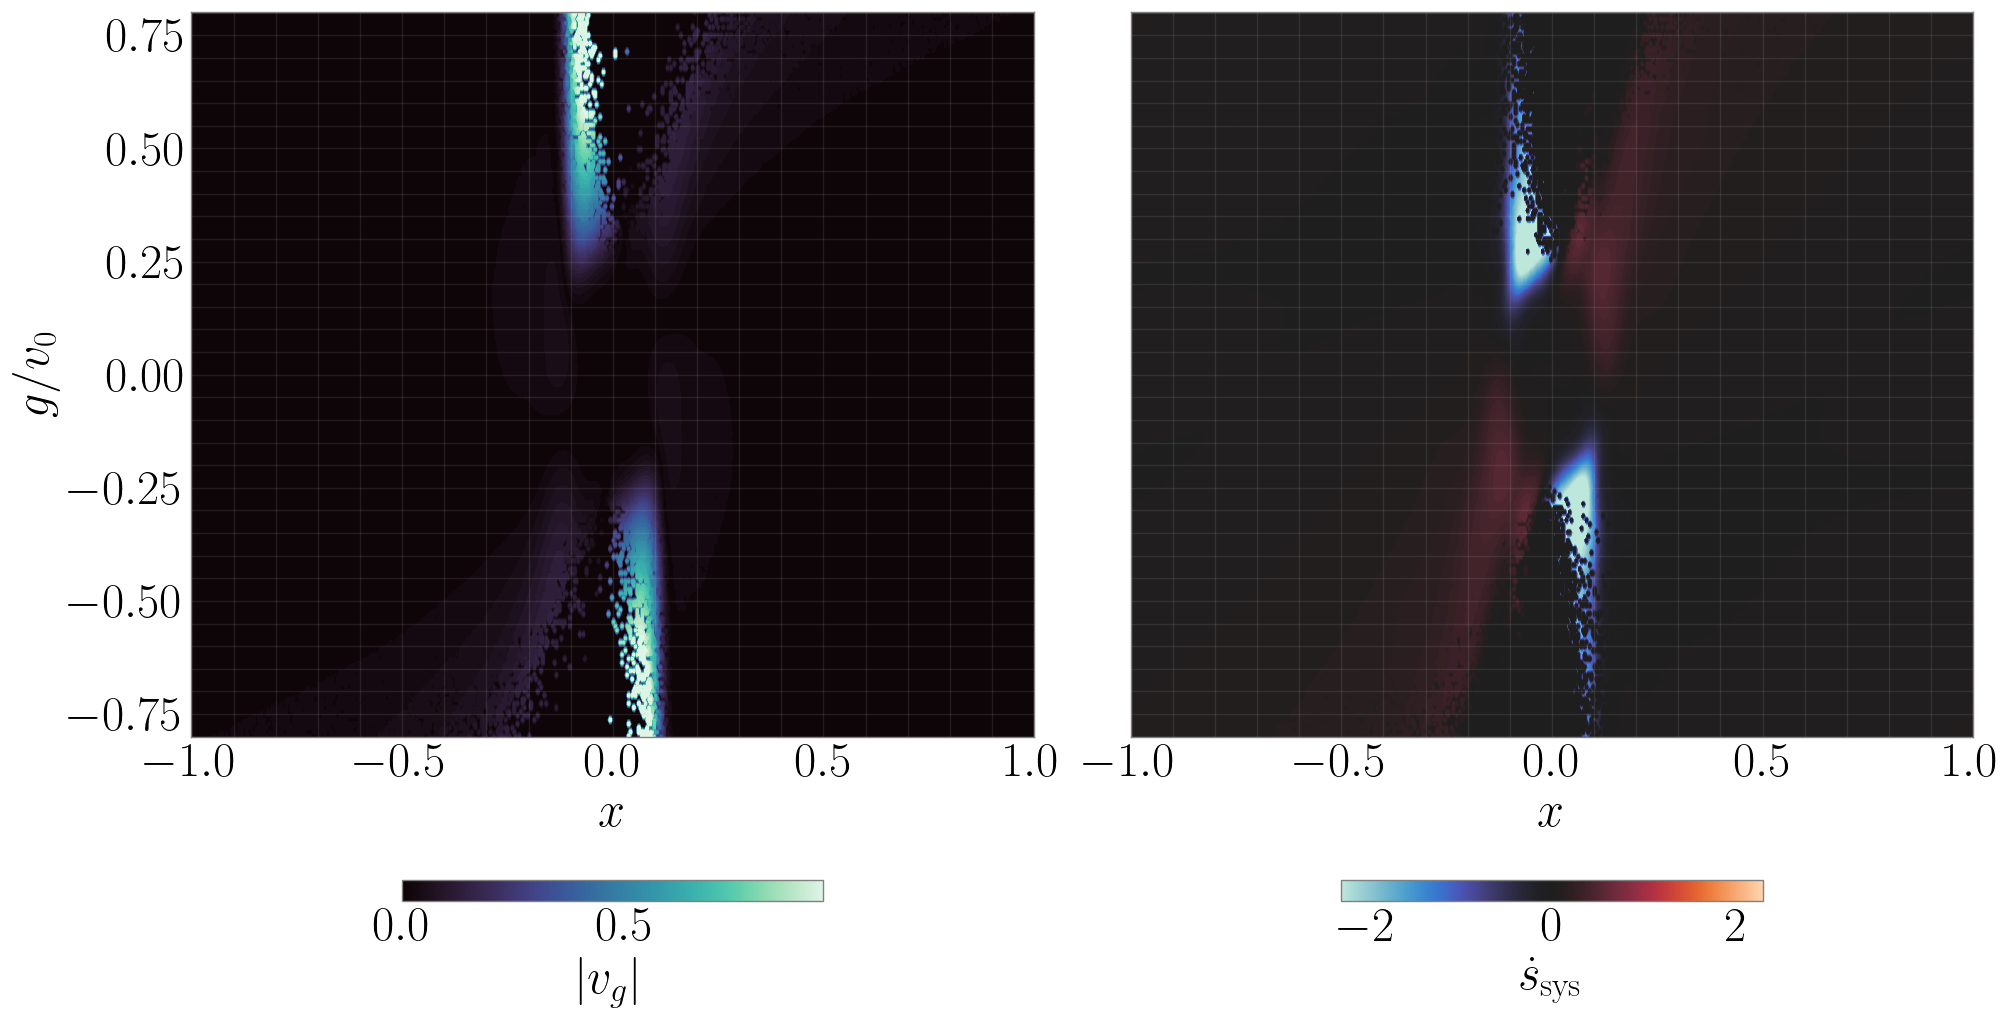

In [15]:
gdot_mags = make_reduced_entropy_density_plot(
    ema_params[0.9999],
    npts=500,
    nbatches=10,
    compute_histogram=False,
    clip_quantile=0.002,
    norm_power=1,
    g_clip_fac=0.35,
    shift_xs=False,
    plot_square=False,
    drop_cbar_labels=False,
    plot_vx=False,
    # output_name=''
    output_name=f'{figure_output}/entropy_scatter.pdf'
)

### Histogram

Starting $|v_g|\cdot\rho$


/state/partition1/job-50776795/ipykernel_772113/2465197830.py:198: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:


Starting $\dot{s}_{\text{sys}}\cdot\rho$


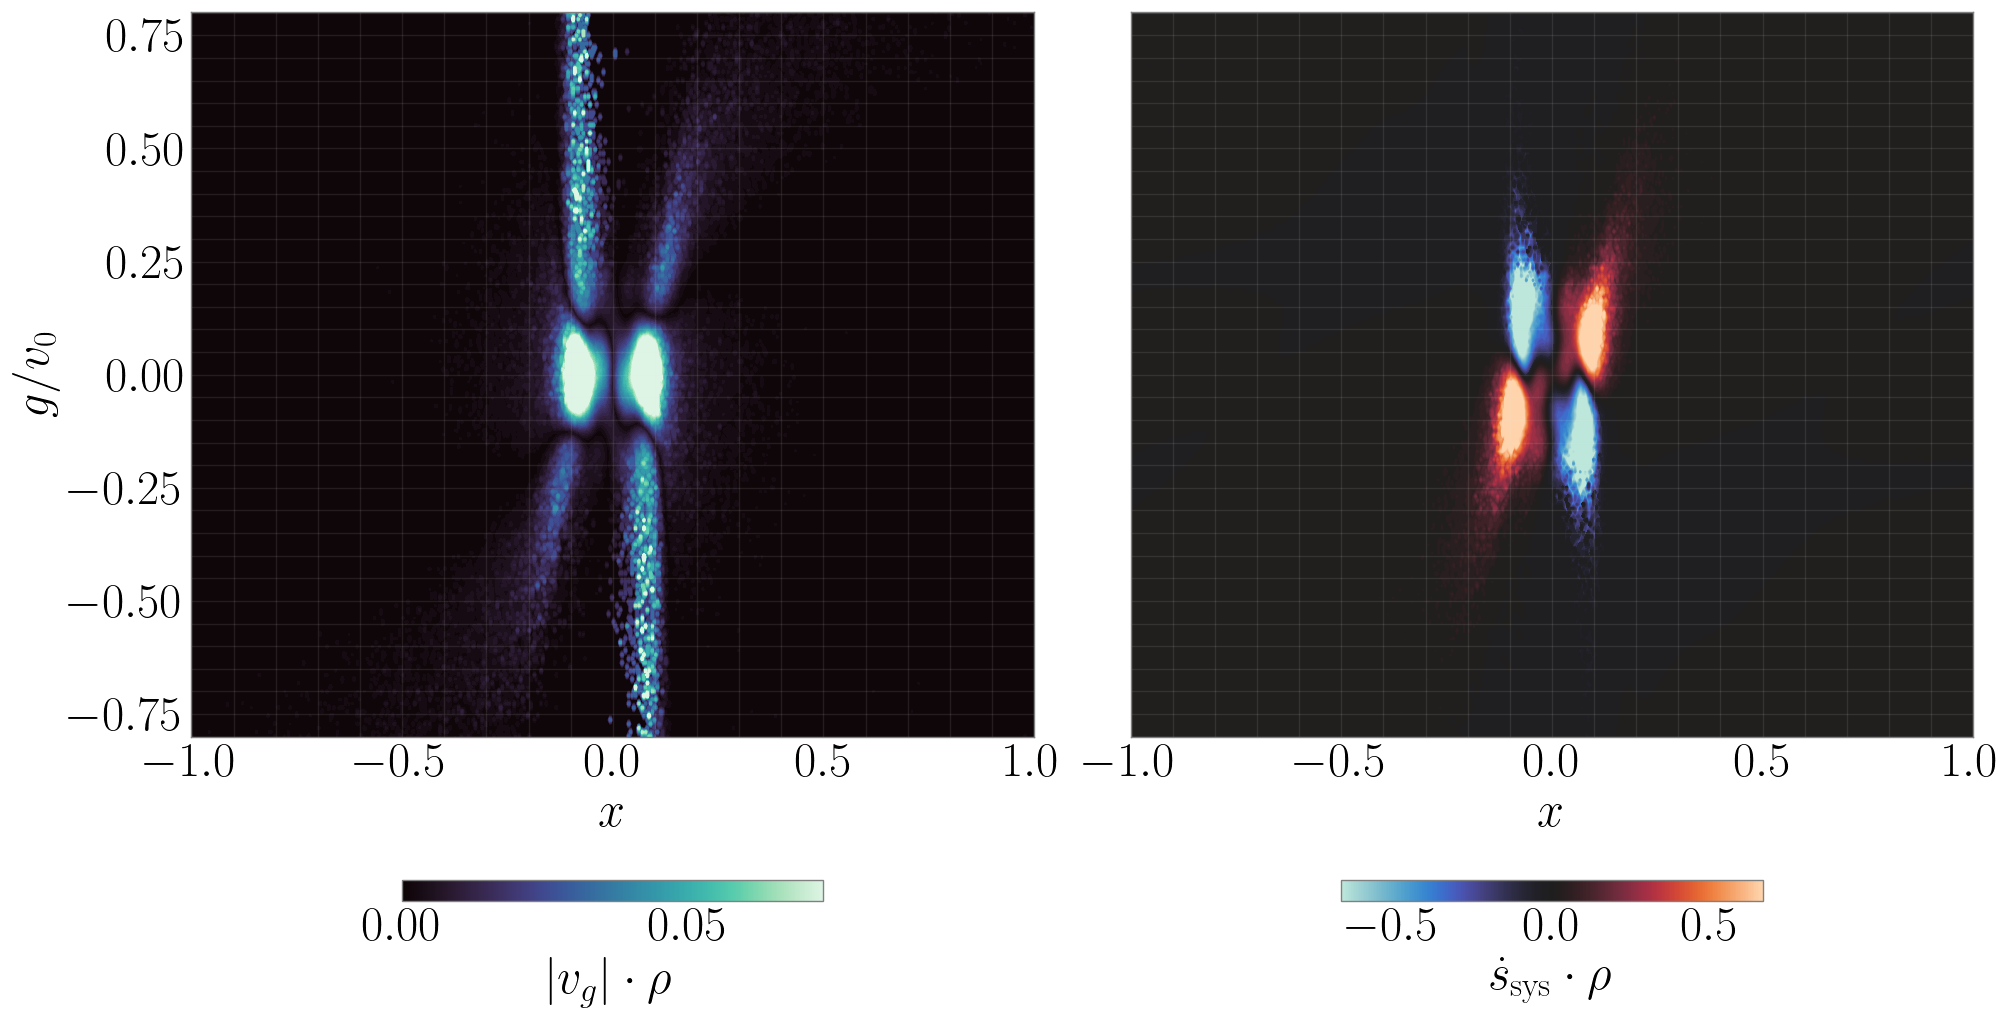

In [16]:
output_name = ''

make_reduced_entropy_density_plot(
    ema_params[0.9999],
    npts=500,
    nbatches=10,
    compute_histogram=True,
    clip_quantile=0.002,
    g_clip_fac=0.35,
    shift_xs=False,
    norm_power=1,
    plot_square=False,
    drop_cbar_labels=False,
    plot_vx=False,
    output_name=f'{figure_output}/entropy_hist.pdf'
    # output_name=''
)

# Density and stochastic trajectories

In [17]:
@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None))
def mask_jumps(
    x: np.ndarray, # [ntrajs, nsteps] (after vmap)
    threshold
):
    """Mask jumps on the torus for better plotting (thanks Claude)"""
    dx = np.diff(x)
    
    # create a mask where True indicates a jump in x
    mask = np.abs(dx) >= threshold
    
    # extend the mask to match the original array length (diff reduces the length)
    mask = np.pad(mask, (0, 1), constant_values=False)
    
    # create "masked" arrays by replacing x values where mask is True with NaN
    x_masked = np.where(mask, np.nan, x)
    
    return x_masked

In [40]:
def make_trajectory_and_density_plot(
    xs: np.ndarray,
    gs: np.ndarray,
    sde_trajs: np.ndarray,
    bins: int,
    levels: int,
    min_g: float,
    max_g: float,
    mask_epsilon: float,
    shift_xs: float,
    output_name: str
) -> None:
    plt.close('all')
    sns.set_palette('deep')

    # convert to displacement coordinates
    gs = np.squeeze(gs[:, 0] - gs[:, 1])
    sde_xs, sde_gs = np.split(sde_trajs, 2, axis=-1)
    sde_gs = sde_gs[:, :, 0] - sde_gs[:, :, 1]

    if shift_xs:
        xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]) + cfg.width)
        sde_xs = systems.wrapped_diff(cfg.width, sde_xs[:, :, 0], sde_xs[:, :, 1] + cfg.width)
        gs = -gs
        sde_gs = -sde_gs
    else:
        xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]))
        sde_xs = systems.wrapped_diff(cfg.width, sde_xs[:, :, 0], sde_xs[:, :, 1])
    
    sde_xs = mask_jumps(sde_xs, 2*cfg.width - mask_epsilon)

    ## define combined figure
    fw        = 8
    fh        = 5.56
    fraction  = 0.1
    shrink    = 0.75
    fontsize  = 22.0
    cmap      = sns.color_palette('mako', as_cmap=True)
    fig, axs  = plt.subplots(nrows=1, ncols=2, figsize=(2*fw, fh), sharey=True, sharex=True, constrained_layout=True)


    ## common plot parameters
    for kk, ax in enumerate(axs.ravel()):
        ax.set_xlim([-1.0, 1.0])
        ax.set_ylim([min_g, max_g])
        ax.grid(which='both', axis='both', color='0.9', alpha=0.025)
        ax.set_xlabel(r"$x$", fontsize=fontsize)
        if kk == 0:
            ax.set_ylabel(r"$g / v_0$", fontsize=fontsize)
        ax.set_xticks([-1.0, -1/2, 0.0, 1/2, 1.0])
        ax.set_yticks([min_g, min_g/2, 0, max_g/2, max_g])
        ax.tick_params(which='both', width=0, length=0, labelsize=fontsize)
        for spine in ax.spines.values():
            spine.set_edgecolor(None)


    ## compute histogram
    hist, xedges, gedges = np.histogram2d(np.squeeze(xs), np.squeeze(gs), bins=bins, density=True)
    xcenters             = xedges[:-1] + np.diff(xedges)
    gcenters             = gedges[:-1] + np.diff(gedges)
    xgrid, ggrid         = np.meshgrid(xcenters, gcenters, indexing='ij')


    ## plot histogram of samples
    axs[1].set_facecolor(sns.color_palette('mako', n_colors=150)[0])
    vmin = float(hist.min())
    vmax = float(hist.max())
    # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    norm = mpl.colors.LogNorm(vmin=1e-2, vmax=vmax)
    ctr  = axs[1].contourf(xgrid, ggrid, hist, cmap=cmap, norm=norm, levels=levels)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=fraction, shrink=shrink, orientation='horizontal')
    # cbar.ax.tick_params(which='both', length=0, labelsize=0)
    cbar.ax.set_xlabel(r"$\rho$", fontsize=fontsize)
    # cbar.set_ticklabels([])
    cbar.outline.set_edgecolor('grey')
    cbar.outline.set_linewidth(0.25)


    # fix weird rasterization
    for c in ctr.collections:
        c.set_edgecolor("face")
        c.set_rasterized(True)

    ## plot SDE trajectories
    axs[0].set_facecolor('k')
    axs[0].plot(sde_xs[:, :].T, sde_gs[:, :].T, alpha=0.25, color='white', lw=0.5)


    if output_name != '':
        fig.patch.set_facecolor('k')
        fig.patch.set_alpha(0.0)
        plt.savefig(output_name, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

In [28]:
ntrajs_rollout = 500
inds           = onp.random.choice(onp.arange(xgs.shape[0]), size=ntrajs_rollout, replace=False)
nsteps         = 1000
init_xgs       = xgs[inds]
noises         = onp.random.randn(ntrajs_rollout, nsteps, 4, 1)
_, sde_trajs   = systems.rollout_trajs(init_xgs, noises, cfg.system.step)
sde_trajs      = np.squeeze(sde_trajs)

/state/partition1/job-50776795/ipykernel_772113/566883739.py:70: UserWarning: Log scale: values of z <= 0 have been masked
  ctr  = axs[1].contourf(xgrid, ggrid, hist, cmap=cmap, norm=norm, levels=levels)
/state/partition1/job-50776795/ipykernel_772113/566883739.py:80: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:


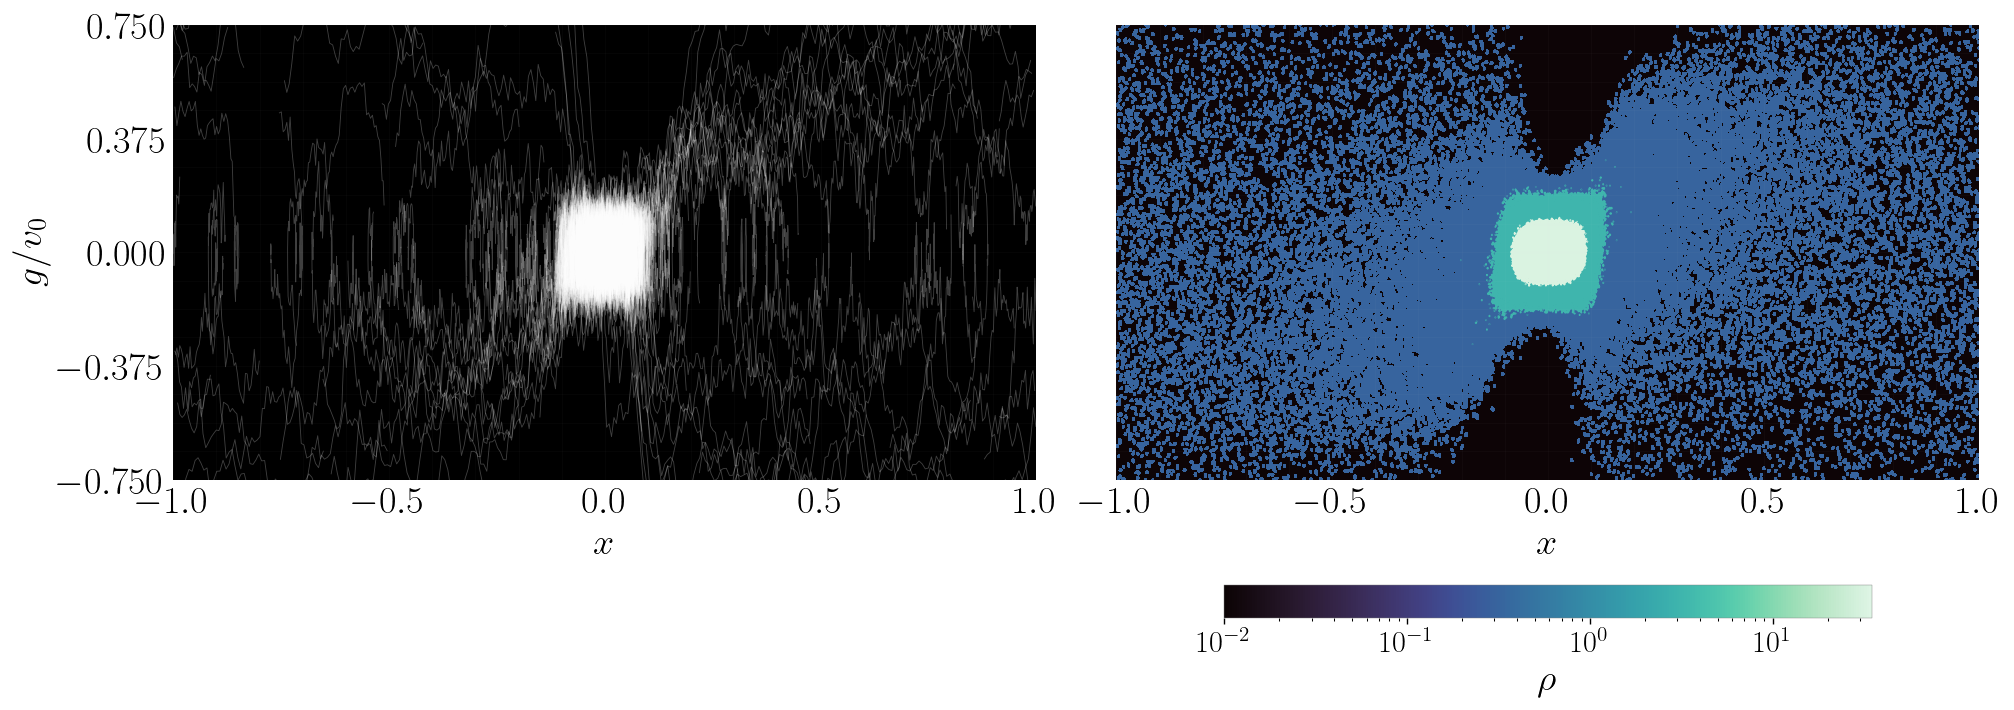

In [42]:
sde_skip = 10

make_trajectory_and_density_plot(
    xs,
    gs,
    sde_trajs[:, ::sde_skip],
    bins=1024,
    levels=32,
    # min_g=-6,
    min_g=-0.75,
    # max_g=6,
    max_g=0.75,
    mask_epsilon=5e-2,
    shift_xs=False,
    # output_name=''
    output_name=f'{figure_output}/sde_density.pdf'
)

# Density alone

In [19]:
def make_density_histograms(
    xs: np.ndarray,
    gs: np.ndarray,
    bins: int,
    min_g: float,
    max_g: float,
    shift_xs: float,
    output_name: str
) -> None:
    plt.close('all')
    sns.set_palette('deep')
    # convert to displacement coordinates
    gs = np.squeeze(gs[:, 0] - gs[:, 1])
    if shift_xs:
        xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]) + cfg.width)
        gs = -gs
    else:
        xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]))
    
    ## define combined figure
    fw = 16  # increased width to accommodate two plots
    fh = 5.56
    fontsize = 22.0
    cmap = sns.color_palette('mako', as_cmap=True)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(fw, fh), sharey=True, sharex=True, constrained_layout=True)
    
    ## common plot parameters
    for kk, ax in enumerate(axs):
        ax.set_xlim([-0.15, 0.15])
        ax.set_ylim([min_g, max_g])
        ax.grid(which='both', axis='both', color='0.9', alpha=0.025)
        ax.set_xlabel(r"$x$", fontsize=fontsize)
        if kk == 0:
            ax.set_ylabel(r"$g$", fontsize=fontsize)
        # ax.set_xticks([-1./0, -1/2, 0.0, 1/2, 1.0])
        # ax.set_yticks([min_g, min_g/2, 0, max_g/2, max_g])
        ax.tick_params(which='both', width=0, length=0, labelsize=fontsize)
        for spine in ax.spines.values():
            spine.set_edgecolor(None)
    
    ## compute histogram
    hist, xedges, gedges = np.histogram2d(np.squeeze(xs), np.squeeze(gs), bins=bins, density=True)
    xcenters = xedges[:-1] + np.diff(xedges)
    gcenters = gedges[:-1] + np.diff(gedges)
    xgrid, ggrid = np.meshgrid(xcenters, gcenters, indexing='ij')
    
    ## plot linear scale histogram
    axs[0].set_facecolor(sns.color_palette('mako', n_colors=150)[0])
    vmin = float(hist.min())
    vmax = float(hist.max())
    norm_linear = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ctr_linear = axs[0].contourf(xgrid, ggrid, hist, cmap=cmap, norm=norm_linear, levels=256)
    cbar_linear = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_linear, cmap=cmap), ax=axs[0], orientation='horizontal', pad=0.1)
    cbar_linear.ax.tick_params(which='both', length=0, labelsize=fontsize-4)
    cbar_linear.set_label(r"$\rho$ (linear scale)", fontsize=fontsize)
    cbar_linear.outline.set_edgecolor('grey')
    cbar_linear.outline.set_linewidth(0.25)
    
    ## plot log scale histogram
    axs[1].set_facecolor(sns.color_palette('mako', n_colors=150)[0])
    norm_log = mpl.colors.LogNorm(vmin=1e-2, vmax=vmax)
    ctr_log = axs[1].contourf(xgrid, ggrid, hist, cmap=cmap, norm=norm_log, levels=256)
    cbar_log = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_log, cmap=cmap), ax=axs[1], orientation='horizontal', pad=0.1)
    cbar_log.ax.tick_params(which='both', length=0, labelsize=fontsize-4)
    cbar_log.set_label(r"$\rho$ (log scale)", fontsize=fontsize)
    cbar_log.outline.set_edgecolor('grey')
    cbar_log.outline.set_linewidth(0.25)
    
    # fix weird rasterization
    for c in ctr_linear.collections + ctr_log.collections:
        c.set_edgecolor("face")
        c.set_rasterized(True)
        
    if output_name != '':
        fig.patch.set_facecolor('k')
        fig.patch.set_alpha(0.0)
        plt.savefig(output_name, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

/state/partition1/job-50634200/ipykernel_791550/1452922841.py:62: UserWarning: Log scale: values of z <= 0 have been masked
  ctr_log = axs[1].contourf(xgrid, ggrid, hist, cmap=cmap, norm=norm_log, levels=256)
/state/partition1/job-50634200/ipykernel_791550/1452922841.py:70: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr_linear.collections + ctr_log.collections:


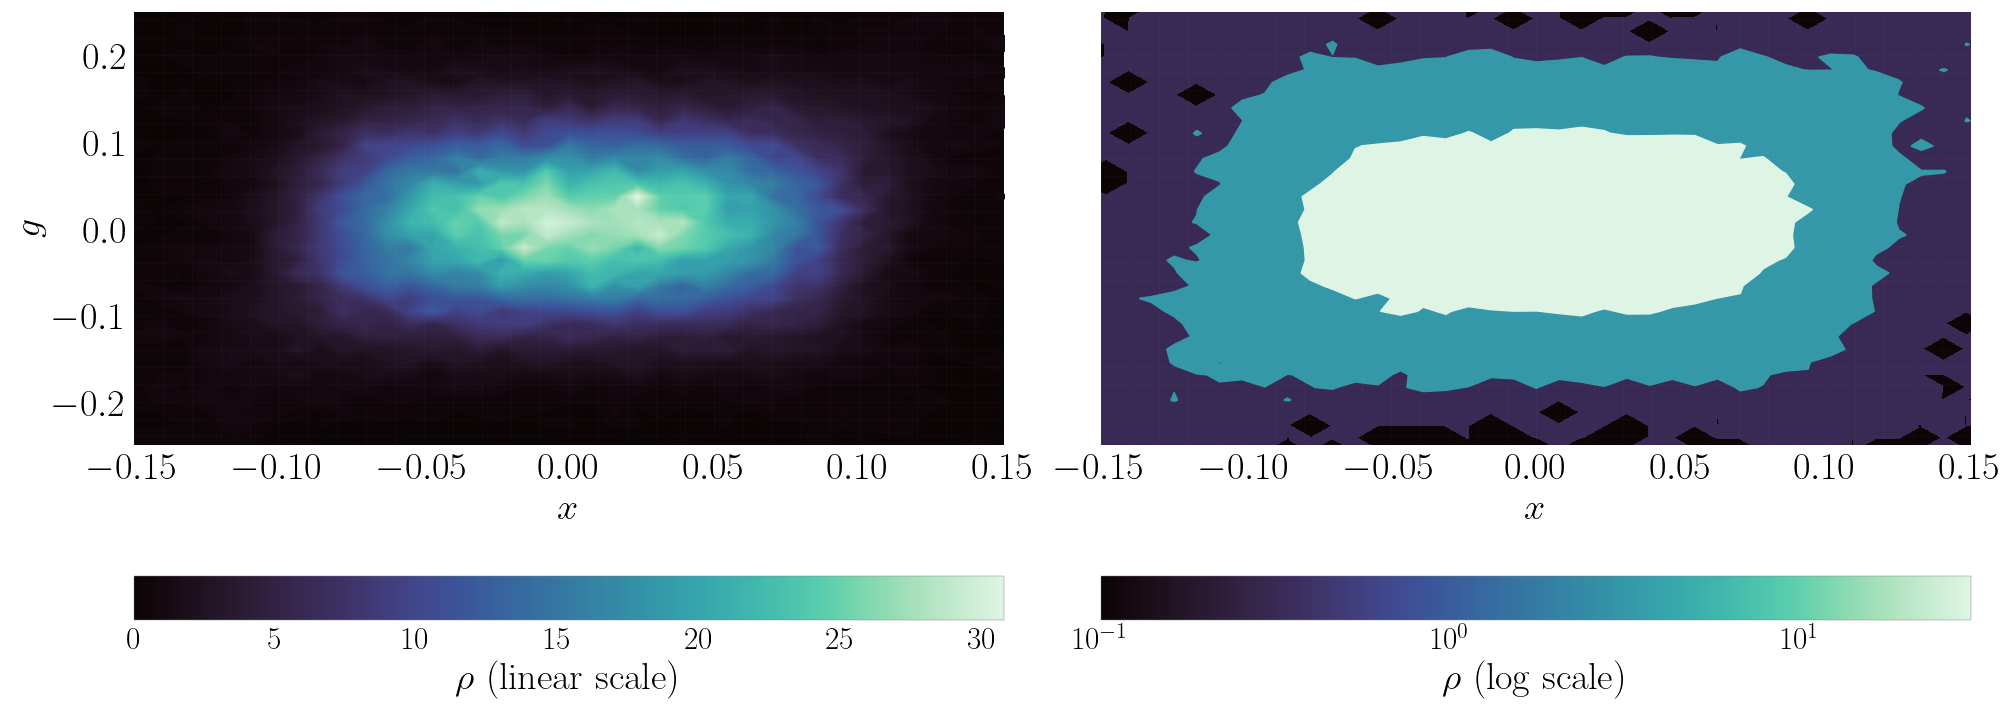

In [38]:
make_density_histograms(
    xs,
    gs,
    bins=256,
    min_g=-0.25,
    max_g=0.25,
    shift_xs=False,
    output_name=''
)

# Phase portrait

In [43]:
def pflow_rhs(
    xgs: np.ndarray, # [2N, d]
    params: Dict
) -> np.ndarray:
    xs, gs = np.split(xgs, 2)
    bxs, bgs = np.split(cfg.system.rhs(xgs), 2)

    if cfg.loss_type == 'score_matching':
        if cfg.eps > 0:
            xdots = bxs - cfg.eps*net.apply(params['x'], xs, gs)
        else:
            xdots = bxs
    
        if cfg.system.rescale_type == 'none':
            gdots = bgs - cfg.gamma*net.apply(params['g'], xs, gs)
        else:
            gdots = bgs - net.apply(params['g'], xs, gs)

    elif cfg.loss_type == 'stratonovich':
        if cfg.eps > 0:
            xdots = net.apply(params['x'], xs, gs)
        else:
            xdots = bxs

        gdots = net.apply(params['g'], xs, gs)

    return xdots, gdots


def step_pflow(
    xgs: np.ndarray, # [2N, d]
    params: Dict,
    dt: float,
) -> np.ndarray:
    xs, gs = np.split(xgs, 2)
    xdots, gdots = pflow_rhs(xgs, params)
    xnexts = systems.torus_project(xs + dt*xdots, cfg.width)
    gnexts = gs + dt*gdots
    return np.concatenate((xnexts, gnexts))


@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None, None, None))
def rollout_trajs_pflow(
    init_xgs: np.ndarray, # [2N, d]
    steps: np.ndarray,   # [nsteps]
    params: Dict,
    dt: float
) -> np.ndarray:
    
    def scan_fn(xg: np.ndarray, step: np.ndarray):
        xgnext = step_pflow(xg, params, dt)
        return xgnext, xgnext

    xg_final, xg_traj = jax.lax.scan(scan_fn, init_xgs, steps)
    return xg_traj


map_pflow_rhs = jax.jit(jax.vmap(jax.vmap(pflow_rhs, in_axes=(0, None)), in_axes=(0, None)))

In [44]:
def make_phase_portrait(
    params: Dict,
    pflow_trajs: np.ndarray,
    min_g: float,
    max_g: float,
    mask_epsilon: float,
    fw: float,
    fh: float,
    fontsize: float,
    arrow_skip_fac: int,
    nbatches: int,
    plot_init: bool,
    plot_arrows: bool,
    plot_curves: bool,
    ntrajs_color: int,
    normalize_arrows: bool,
    shift_xs: bool,
    output_name: str
) -> None:
    plt.close('all')
    sns.set_palette('deep')


    ## compute flow directions
    if plot_arrows:
        bs         = pflow_trajs.shape[0] // nbatches
        vxs = onp.zeros((pflow_trajs.shape[0], pflow_trajs.shape[1], pflow_trajs.shape[2]//2, 1))
        vgs = onp.zeros_like(vxs)
        
        for curr_batch in range(nbatches):
            lb = curr_batch*bs
            ub = lb + bs
            vxs[lb:ub], vgs[lb:ub] = map_pflow_rhs(pflow_trajs[lb:ub], params)
            
        vxs = np.squeeze(vxs[:, :, 0] - vxs[:, :, 1])
        vgs = np.squeeze(vgs[:, :, 0] - vgs[:, :, 1])

        print(vxs.shape, vgs.shape)
        if normalize_arrows:
            vxs /= onp.linalg.norm(vxs, axis=-1)[:, None]
            vgs /= onp.linalg.norm(vgs, axis=-1)[:, None]

    ## convert to displacement coordinates
    pxs, pgs = np.split(pflow_trajs, 2, axis=-2)

    pgs = np.squeeze(pgs[:, :, 0] - pgs[:, :, 1])
    if shift_xs:
        pxs = np.squeeze(systems.wrapped_diff(cfg.width, pxs[:, :, 0], pxs[:, :, 1] + cfg.width))
        pgs = -pgs
    else:
        pxs = np.squeeze(systems.wrapped_diff(cfg.width, pxs[:, :, 0], pxs[:, :, 1]))

    if mask_epsilon > 0:
        pxs = mask_jumps(pxs, 2*cfg.width - mask_epsilon)
    
    min_x, max_x = -cfg.width, cfg.width

    ## set up figure
    fig, ax = plt.subplots(figsize=(fw, fh), constrained_layout=True)


    ## plot trajectories with arrows on top
    for curr_traj in range(pxs.shape[0]):
        # plot cycles
        if plot_curves:
            ax.plot(
                pxs[curr_traj, :], 
                pgs[curr_traj, :], 
                color='lavender', 
                alpha=0.5, 
                lw=0.75
            )
        
        if plot_init:
            ax.scatter(
                pxs[:, 0],
                pgs[:, 0],
                s=0.05,
                alpha=0.25,
                marker='x',
                color='white'
            )

        if plot_arrows:
            ax.quiver(
                pxs[curr_traj, ::arrow_skip_fac], 
                pgs[curr_traj, ::arrow_skip_fac], 
                vxs[curr_traj, ::arrow_skip_fac],
                vgs[curr_traj, ::arrow_skip_fac],
                color='lavender', 
                alpha=0.75,
                # scale=100,
                scale=5,
                headwidth=3,
                width=5e-4,
                minlength=0
#                 headlength=10
            )

    if ntrajs_color > 0:
        inds = onp.random.choice(pxs.shape[0], size=ntrajs_color)

        for kk, ind in enumerate(inds):
            ax.plot(
                pxs[ind, :], 
                pgs[ind, :], 
                color=f'C{kk}', 
                alpha=1.0, 
                lw=0.75
            )

    ax.grid(which='both', axis='both', color='0.9', alpha=0.25)
    ax.set_facecolor('k')
    ax.set_xlabel(r"$x$", fontsize=fontsize)
    ax.set_ylabel(r"$g$", fontsize=fontsize)
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_g, max_g])
    # ax.set_xticks([-1, -1/2, 0, 1/2, 1])
    ax.tick_params(which='both', width=0, length=0, labelsize=fontsize)


    if output_name != '':
        fig.patch.set_facecolor('k')
        fig.patch.set_alpha(0.0)
        plt.savefig(output_name, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

### Construct inits

#### diagonal line

In [118]:
### set up initial conditions for phase portrait
ntrajs_pflow = 160


## symmetric line
inits      = onp.zeros((ntrajs_pflow, 4, cfg.d))


lb_x, ub_x = -cfg.width, cfg.width
# lb_g, ub_g = -7.5, 7.5
lb_g, ub_g = -1/4, 1/4


inits[:ntrajs_pflow//2, 0] = onp.linspace( lb_x,  ub_x, ntrajs_pflow//2).reshape((-1, cfg.d)) # x1
inits[:ntrajs_pflow//2, 2] = onp.linspace( lb_g,  ub_g, ntrajs_pflow//2).reshape((-1, cfg.d)) # g1
inits[ntrajs_pflow//2:, 0] = onp.linspace( lb_x,  ub_x, ntrajs_pflow//2).reshape((-1, cfg.d)) # x1
inits[ntrajs_pflow//2:, 2] = onp.linspace( ub_g,  lb_g, ntrajs_pflow//2).reshape((-1, cfg.d)) # g1


# inits[:ntrajs_pflow//2, 0] = onp.linspace( -0.75,  0.75, ntrajs_pflow//2).reshape((-1, cfg.d)) # x1
# inits[ntrajs_pflow//2:, 0] = onp.linspace( -0.75,  0.75, ntrajs_pflow//2).reshape((-1, cfg.d)) # x1
# inits[ntrajs_pflow//2:, 2] = onp.linspace(-0.25, 0.25, ntrajs_pflow//2).reshape((-1, cfg.d)) # g1


## roll out trajectories
dt_pflow         = 1e-2
# rollout_fac      = 2.5
rollout_fac      = 1.0
nsteps_pflow     = int((rollout_fac / cfg.gamma) / np.abs(dt_pflow) + 0.5)
pflow_trajs_fwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], dt_pflow))
pflow_trajs_bwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], -dt_pflow))
pflow_trajs      = onp.concatenate((pflow_trajs_fwd, pflow_trajs_bwd))

#### horizonal and vertical lines (assuming shift x)

In [46]:
### set up initial conditions for phase portrait
ntrajs_pflow = 200

## symmetric line
inits      = onp.zeros((ntrajs_pflow, 4, cfg.d))

lb_x, ub_x = -cfg.width, cfg.width
lb_g, ub_g = -7.5, 7.5

inits[:ntrajs_pflow//2, 0] = onp.linspace( lb_x,  ub_x, ntrajs_pflow//2).reshape((-1, cfg.d)) # x1
inits[ntrajs_pflow//2:, 2] = onp.linspace( lb_g,  ub_g, ntrajs_pflow//2).reshape((-1, cfg.d)) # g1
inits[:, 1]                = cfg.width                                                        # x2

## roll out trajectories
dt_pflow     = 1e-2
rollout_fac  = 1.0
nsteps_pflow = int((rollout_fac / cfg.gamma) / np.abs(dt_pflow) + 0.5)
pflow_trajs  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], dt_pflow))

#### horizonal and vertical lines (assuming no shift x)

In [47]:
### set up initial conditions for phase portrait
ntrajs_pflow = 300

## symmetric line
inits      = onp.zeros((ntrajs_pflow, 4, cfg.d))

lb_x, ub_x = -cfg.width, cfg.width
# lb_g, ub_g = -2.5, 2.5
lb_g, ub_g = -0.5, 0.5

inits[:ntrajs_pflow//2, 0] = onp.linspace( lb_x,  ub_x, ntrajs_pflow//2).reshape((-1, cfg.d)) # x1
inits[ntrajs_pflow//2:, 2] = onp.linspace( lb_g,  ub_g, ntrajs_pflow//2).reshape((-1, cfg.d)) # g1

## roll out trajectories
dt_pflow         = 1e-2
# rollout_fac      = 0.25
rollout_fac      = 0.1
nsteps_pflow     = int((rollout_fac / cfg.gamma) / np.abs(dt_pflow) + 0.5)
pflow_trajs_fwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], dt_pflow))
pflow_trajs_bwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], -dt_pflow))
pflow_trajs      = onp.concatenate((pflow_trajs_fwd, pflow_trajs_bwd))

#### vertical line only

In [45]:
### set up initial conditions for phase portrait
ntrajs_pflow = 100

## symmetric line
inits      = onp.zeros((ntrajs_pflow, 4, cfg.d))
lb_g, ub_g = -0.25, 0.25

inits[:, 2] = onp.linspace( lb_g,  ub_g, ntrajs_pflow).reshape((-1, cfg.d)) # g1

## roll out trajectories
dt_pflow         = 1e-2
# rollout_fac      = 0.25
rollout_fac      = 0.25
nsteps_pflow     = int((rollout_fac / cfg.gamma) / np.abs(dt_pflow) + 0.5)
pflow_trajs_fwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], dt_pflow))
pflow_trajs_bwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], -dt_pflow))
pflow_trajs      = onp.concatenate((pflow_trajs_fwd, pflow_trajs_bwd))

#### random from stationary density

In [97]:
### set up initial conditions for phase portrait
ntrajs_pflow = 200
inds = onp.random.choice(onp.arange(xgs.shape[0]), size=ntrajs_pflow, replace=False)
inits = xgs[inds]


## roll out trajectories
dt_pflow     = 1e-2
rollout_fac  = 0.1
nsteps_pflow = int((rollout_fac / cfg.gamma) / np.abs(dt_pflow) + 0.5)
pflow_trajs_fwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], dt_pflow))
pflow_trajs_bwd  = onp.array(rollout_trajs_pflow(inits, np.arange(nsteps_pflow), ema_params[0.9999], -dt_pflow))
pflow_trajs      = onp.concatenate((pflow_trajs_fwd, pflow_trajs_bwd))

### visualize

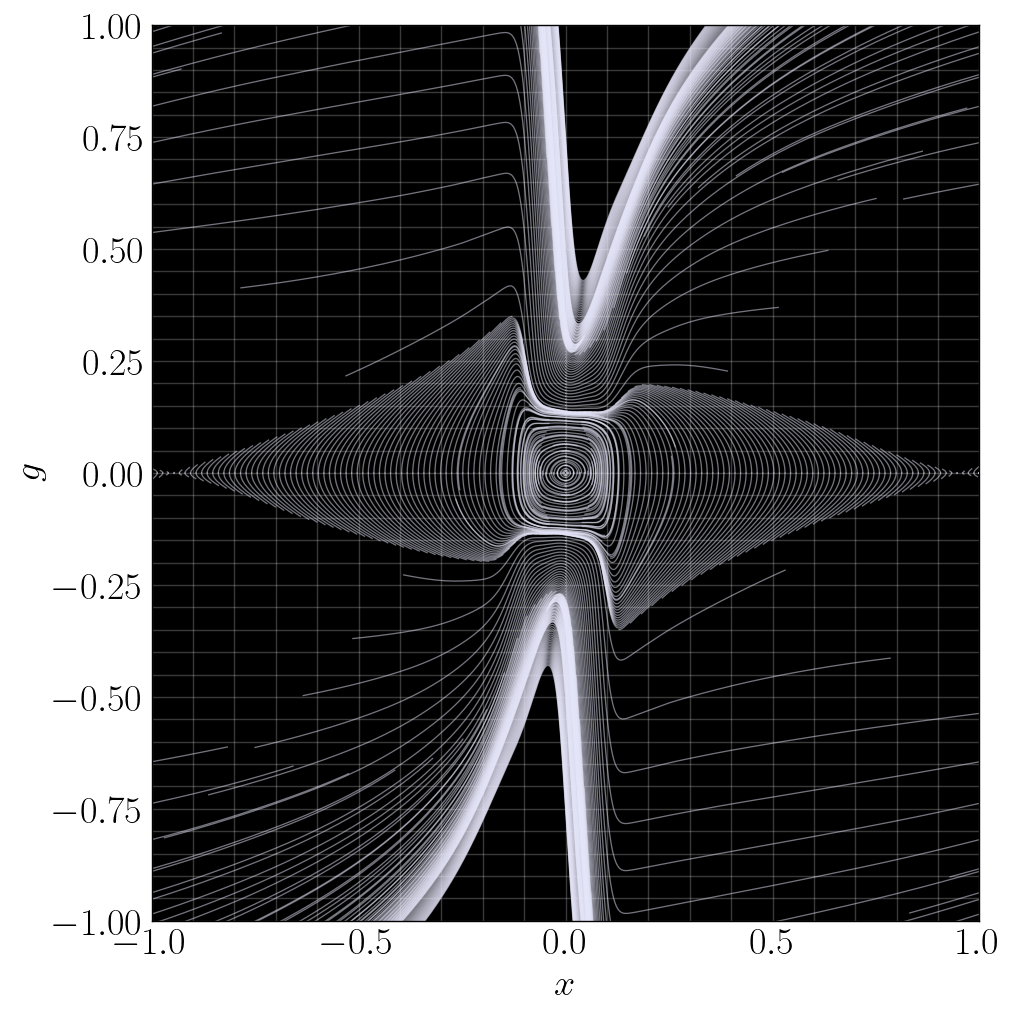

In [50]:
make_phase_portrait(
    params,
    pflow_trajs,
    min_g=-1,
    max_g=1,
    mask_epsilon=1e-2,
    fw=8,
    fh=8,
    fontsize=22,
    arrow_skip_fac=250,
    nbatches=10,
    plot_init=False,
    plot_arrows=False,
    plot_curves=True,
    ntrajs_color=0,
    normalize_arrows=False,
    shift_xs=False,
    # output_name=''
    output_name=f'{figure_output}/phase_portrait.pdf'
)

# Combined phase portrait + entropy plots

In [51]:
def make_combined_plot(
    params: Dict,
    pflow_trajs: np.ndarray,
    xgs: np.ndarray,
    npts: int,
    nbatches: int,
    compute_histogram: bool,
    clip_quantile: float,
    g_clip_fac: float,
    mask_epsilon: float,
    fw: float,
    fh: float,
    fontsize: float,
    arrow_skip_fac: int,
    plot_init: bool,
    plot_arrows: bool,
    plot_curves: bool,
    ntrajs_color: int,
    normalize_arrows: bool,
    output_name: str
) -> None:
    plt.close('all')
    sns.set_palette('deep')

    # Common calculations
    batch_size = cfg.ntrajs // nbatches
    xs = onp.zeros((cfg.ntrajs, 2, 1))
    gs = onp.zeros((cfg.ntrajs, 2, 1))
    vxs = onp.zeros((cfg.ntrajs, 2, 1))
    vgs = onp.zeros((cfg.ntrajs, 2, 1))
    div_vgs = onp.zeros((cfg.ntrajs, 2))
    
    for curr_batch in range(nbatches):
        lb = batch_size * curr_batch
        ub = lb + batch_size
        (
            xs[lb:ub],
            gs[lb:ub],
            vxs[lb:ub],
            vgs[lb:ub],
            _, _,
            _, div_vgs[lb:ub],
            _, _
        ) = learn.map_oned_output_info(xgs[lb:ub], params)

    # Compute displacement coordinates
    gs = np.squeeze(gs[:, 0] - gs[:, 1])
    xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]))
    vxs = np.squeeze(vxs[:, 0] - vxs[:, 1])
    vgs = np.squeeze(vgs[:, 0] - vgs[:, 1])
    div_vgs = np.squeeze(div_vgs[:, 0] + div_vgs[:, 1])  # Sum because of the difference in coordinates

    # Compute norms and entropy production rates
    gdot_mags = np.abs(vgs)
    s_sys = div_vgs  # \dot{s}_{sys} corresponds to div(v_g)

    # Grid quantities
    pointwise_quantities = [gdot_mags, s_sys]
    gridded_quantities = onp.zeros((2, npts, npts))
    xgrid_plots, ggrid_plots = onp.zeros((2, npts, npts)), onp.zeros((2, npts, npts))

    for jj in range(2):
        gridded_quantities[jj], xedges, gedges = np.histogram2d(
            xs, gs, weights=pointwise_quantities[jj], bins=npts, density=False
        )

        multiplicity = onp.array(np.histogram2d(xs, gs, bins=(xedges, gedges), density=False)[0])
        inds = (multiplicity <= (0.01 * np.mean(multiplicity)))
        multiplicity[inds] = 1.0
        gridded_quantities[jj][inds] = 0.0
        gridded_quantities[jj] /= multiplicity

        if compute_histogram:
            density = np.array(np.histogram2d(xs, gs, bins=(xedges, gedges), density=True)[0])
            gridded_quantities[jj] *= density

        curr_xgrid, curr_ggrid = np.meshgrid(xedges, gedges, indexing='ij')
        xgrid_plots[jj] = curr_xgrid[:-1, :-1] + 0.5 * np.diff(xedges)[:, None]
        ggrid_plots[jj] = curr_ggrid[:-1, :-1] + 0.5 * np.diff(gedges)[None, :]

    # Set up the figure
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(fw * 3, fh), sharex=True, sharey=True, constrained_layout=True)

    min_x, max_x = -cfg.width, cfg.width
    min_g, max_g = g_clip_fac * gs.min(), g_clip_fac * gs.max()
    min_g = min(min_g, -max_g)
    max_g = max(-min_g, max_g)

    for kk, ax in enumerate(axs):
        ax.set_xlim([min_x, max_x])
        ax.set_ylim([min_g, max_g])
        ax.set_xticks([-1, -1/2, 0, 1/2, 1])
        ax.grid(which='both', axis='both', color='0.9', alpha=0.1)
        ax.tick_params(which='both', width=0, length=0, labelsize=fontsize)
        ax.set_xlabel(r"$x$", fontsize=fontsize)

        if kk == 0:
            ax.set_ylabel(r"$g / v_0$", fontsize=fontsize)

        for spine in ax.spines.values():
            spine.set_edgecolor('grey')

    # Phase portrait (first panel)
    ax = axs[0]
    pxs, pgs = np.split(pflow_trajs, 2, axis=-2)
    pgs = np.squeeze(pgs[:, :, 0] - pgs[:, :, 1])
    pxs = np.squeeze(systems.wrapped_diff(cfg.width, pxs[:, :, 0], pxs[:, :, 1]))
    
    if mask_epsilon > 0:
        pxs = mask_jumps(pxs, 2 * cfg.width - mask_epsilon)

    for curr_traj in range(pxs.shape[0]):
        if plot_curves:
            ax.plot(pxs[curr_traj, :], pgs[curr_traj, :], color='lavender', alpha=0.5, lw=0.75)
        
        if plot_init:
            ax.scatter(pxs[:, 0], pgs[:, 0], s=0.05, alpha=0.25, marker='x', color='white')
        
        if plot_arrows:
            ax.quiver(
                pxs[curr_traj, ::arrow_skip_fac], 
                pgs[curr_traj, ::arrow_skip_fac], 
                vxs[curr_traj, ::arrow_skip_fac],
                vgs[curr_traj, ::arrow_skip_fac],
                color='lavender', 
                alpha=0.75,
                scale=5,
                headwidth=3,
                width=5e-4,
                minlength=0
            )

    if ntrajs_color > 0:
        inds = np.random.choice(pxs.shape[0], size=ntrajs_color)
        for kk, ind in enumerate(inds):
            ax.plot(pxs[ind, :], pgs[ind, :], color=f'C{kk}', alpha=1.0, lw=0.75)

    ax.set_facecolor('k')

    # |v_g| plot (second panel)
    ax = axs[1]
    vmin = np.quantile(gridded_quantities[0], q=clip_quantile)
    vmax = np.quantile(gridded_quantities[0], q=(1-clip_quantile))
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmap = sns.color_palette('mako', as_cmap=True)

    ctr = ax.contourf(xgrid_plots[0], ggrid_plots[0], gridded_quantities[0], cmap=cmap, norm=norm, levels=100)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.2, shrink=0.5, orientation='horizontal')
    cbar.ax.tick_params(which='both', labelsize=fontsize, width=0, length=0)
    if compute_histogram:
        cbar.ax.set_xlabel(r"$|v_g| \cdot \rho$", fontsize=fontsize)
    else:
        cbar.ax.set_xlabel(r"$|v_g|$", fontsize=fontsize)    
    cbar.outline.set_edgecolor('grey')

    for c in ctr.collections:
        c.set_edgecolor("face")
        c.set_rasterized(True)

    # \dot{s}_{sys} plot (third panel)
    ax = axs[2]
    vmin = np.quantile(gridded_quantities[1], q=clip_quantile)
    vmax = np.quantile(gridded_quantities[1], q=(1-clip_quantile))
    vmin = min(vmin, -vmax)
    vmax = max(vmax, -vmin)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmap = sns.color_palette('icefire', as_cmap=True)

    ctr = ax.contourf(xgrid_plots[1], ggrid_plots[1], gridded_quantities[1], cmap=cmap, norm=norm, levels=100)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.2, shrink=0.5, orientation='horizontal')
    cbar.ax.tick_params(which='both', labelsize=fontsize, width=0, length=0)

    if compute_histogram:
        cbar.ax.set_xlabel(r"$\dot{s}_{\text{sys}} \cdot \rho$", fontsize=fontsize)
    else:
        cbar.ax.set_xlabel(r"$\dot{s}_{\text{sys}}$", fontsize=fontsize)

    cbar.outline.set_edgecolor('grey')

    for c in ctr.collections:
        c.set_edgecolor("face")
        c.set_rasterized(True)

    if output_name != '':
        fig.patch.set_facecolor('k')
        fig.patch.set_alpha(0.0)
        plt.savefig(output_name, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

/state/partition1/job-50776795/ipykernel_772113/3866600072.py:156: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:
/state/partition1/job-50776795/ipykernel_772113/3866600072.py:180: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:


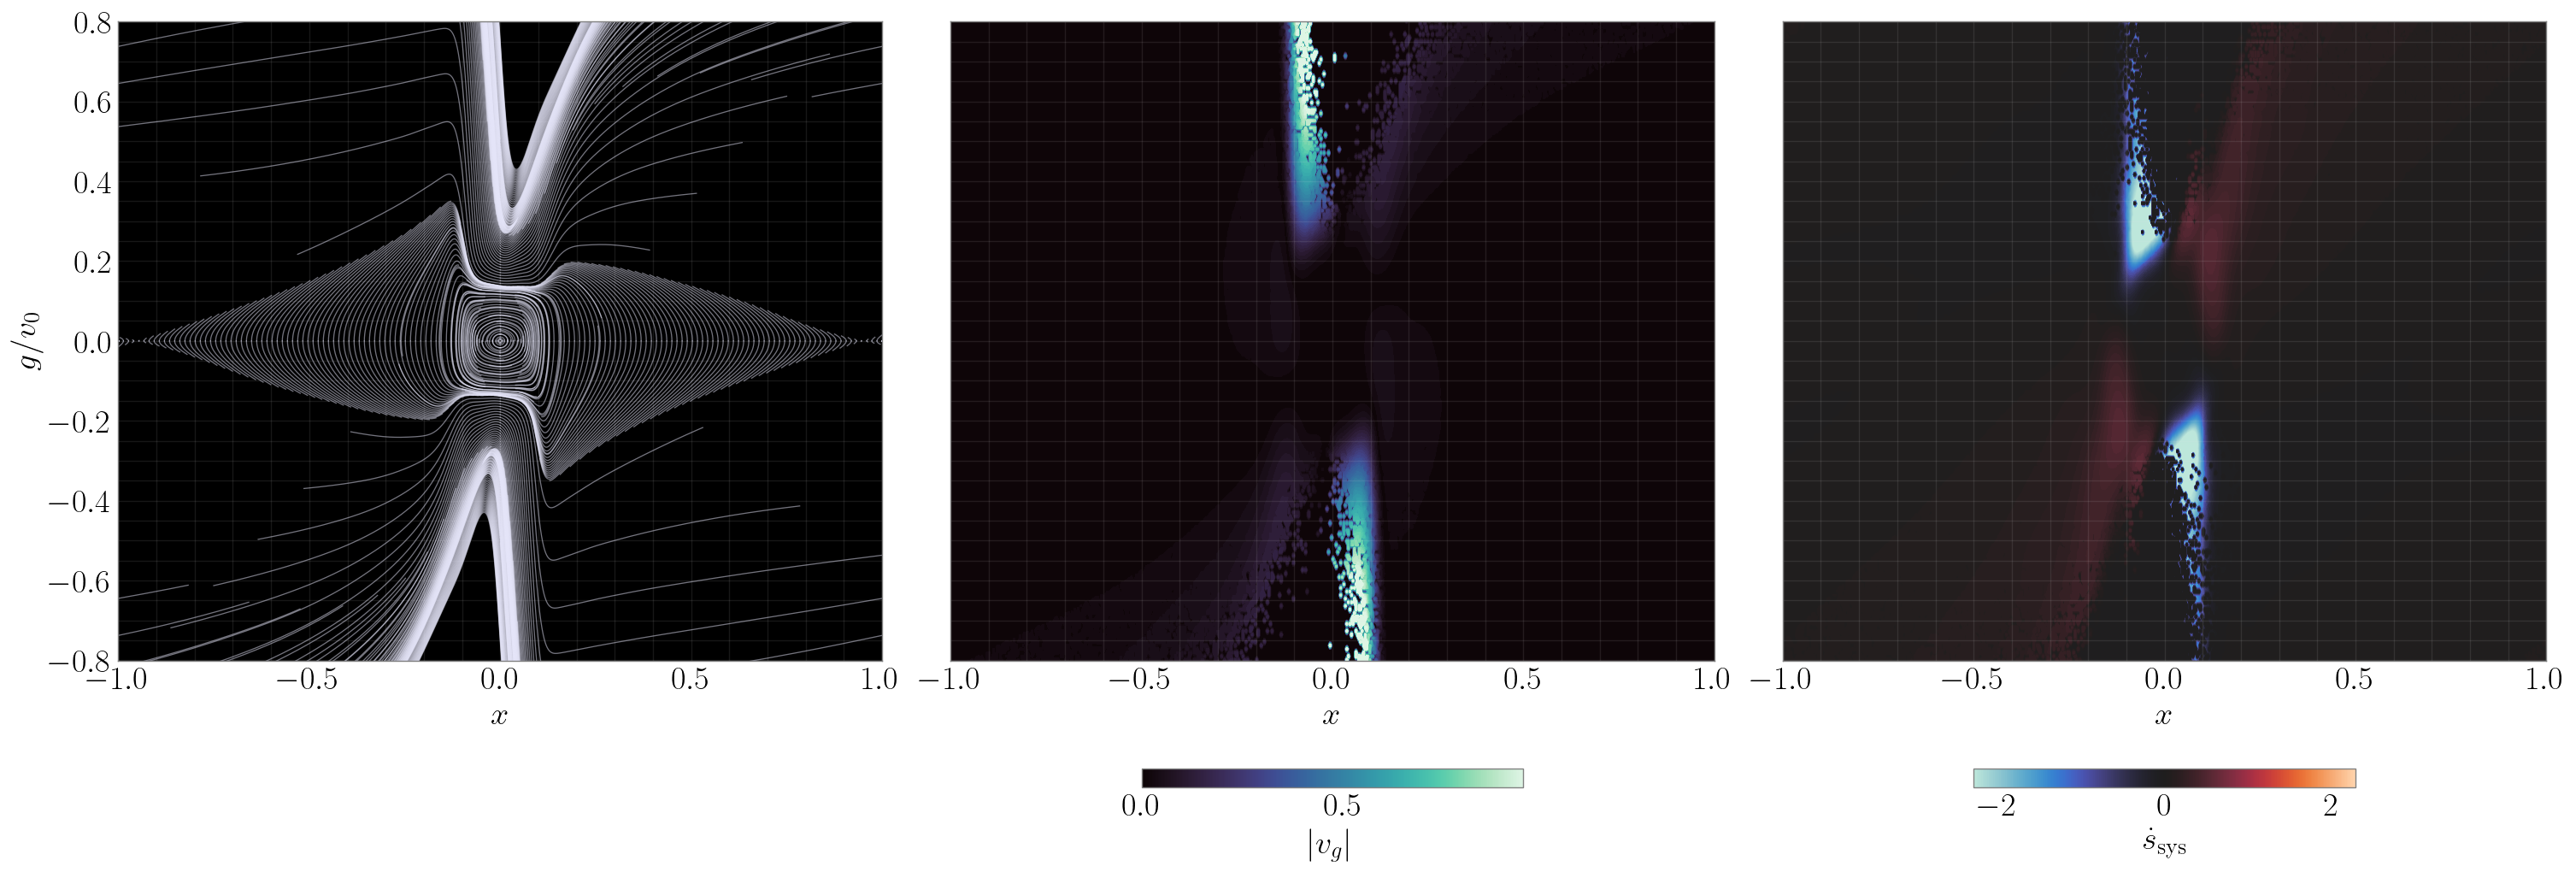

In [52]:
make_combined_plot(
    params=ema_params[0.9999],
    pflow_trajs=pflow_trajs,
    xgs=xgs,
    npts=500,
    nbatches=10,
    compute_histogram=False,
    clip_quantile=0.002,
    g_clip_fac=0.35,
    mask_epsilon=1e-2,
    fw=8,
    fh=8,
    fontsize=22,
    arrow_skip_fac=250,
    plot_init=False,
    plot_arrows=False,
    plot_curves=True,
    ntrajs_color=0,
    normalize_arrows=False,
    # output_name=''
    output_name='lowd_pp_scatter.pdf'
)

/state/partition1/job-50776795/ipykernel_772113/3866600072.py:156: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:
/state/partition1/job-50776795/ipykernel_772113/3866600072.py:180: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:


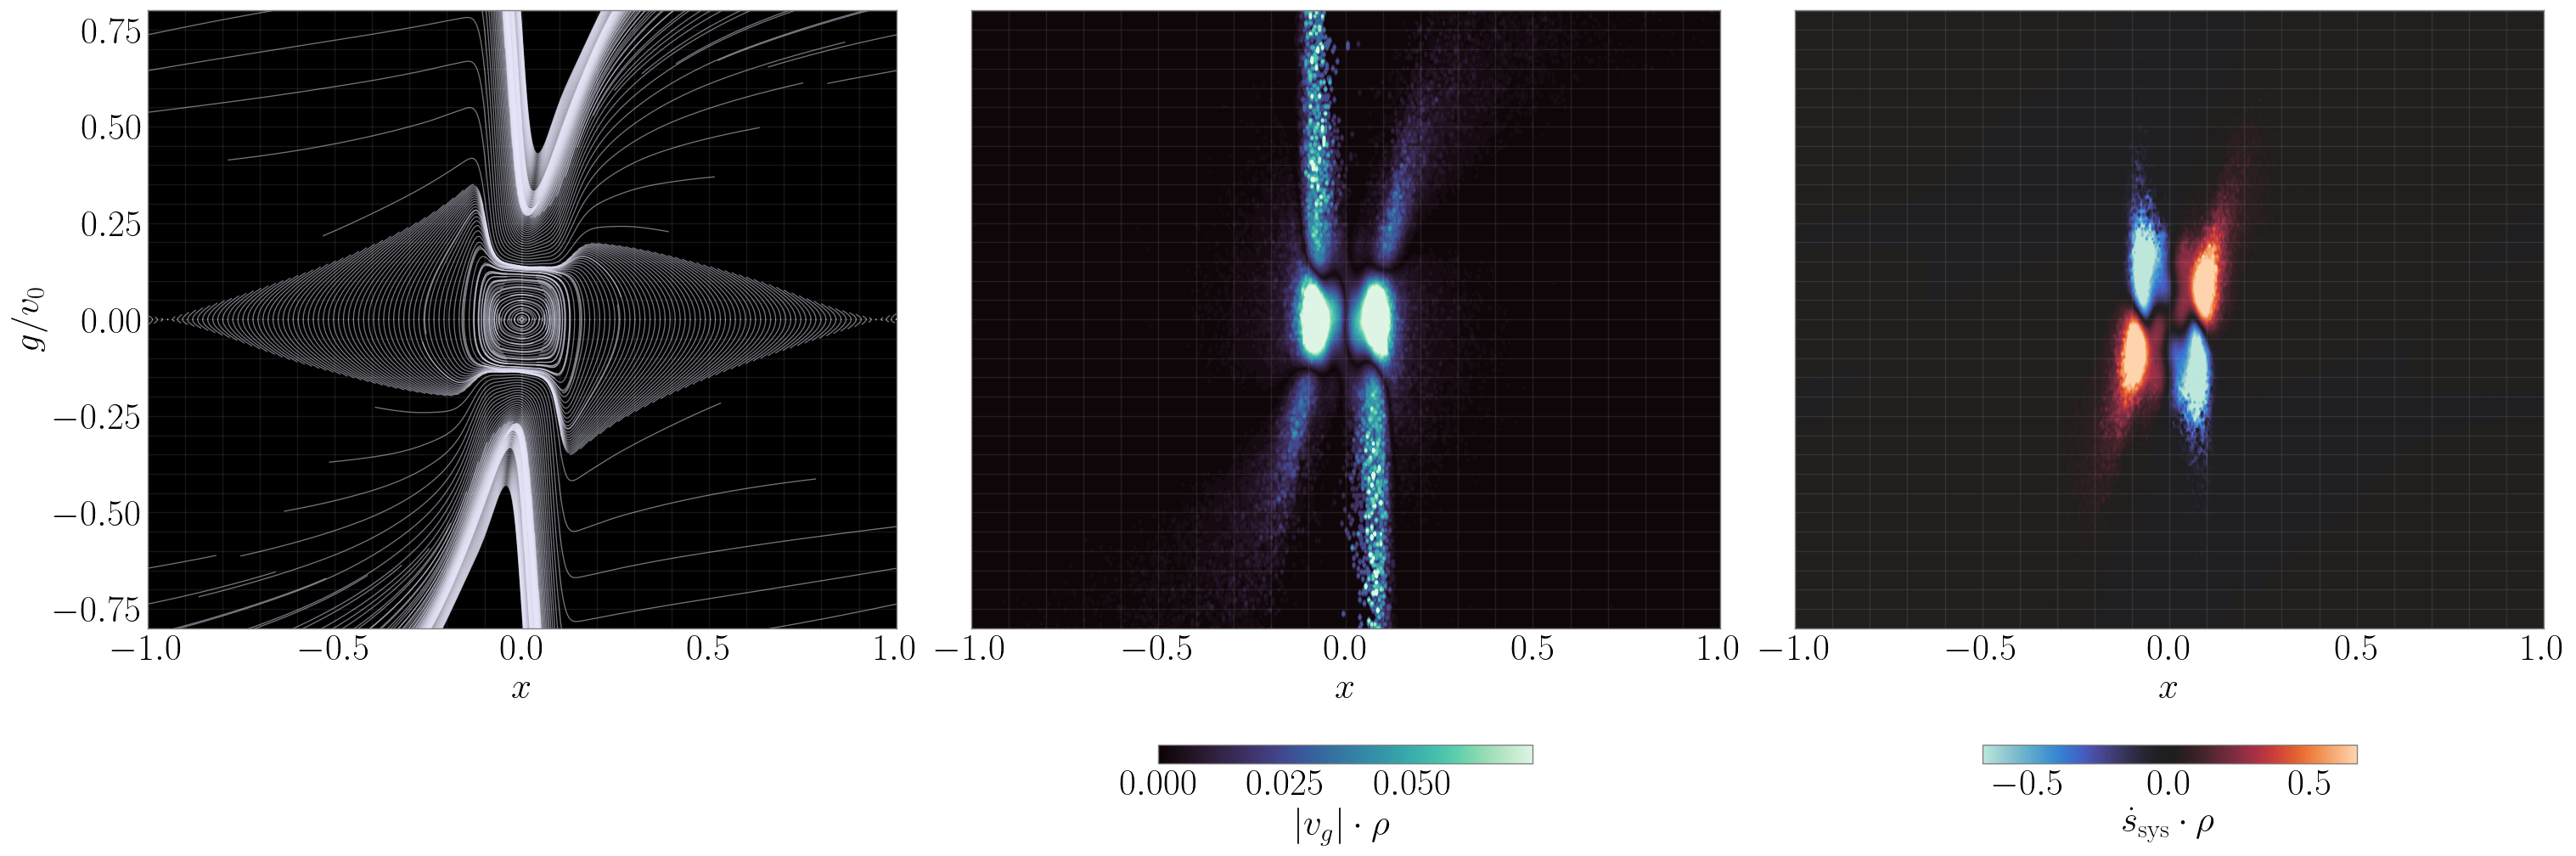

In [53]:
make_combined_plot(
    params=ema_params[0.9999],
    pflow_trajs=pflow_trajs,
    xgs=xgs,  # You'll need to provide this from your data
    npts=500,
    nbatches=10,
    compute_histogram=True,
    clip_quantile=0.002,
    g_clip_fac=0.35,
    mask_epsilon=1e-2,
    fw=8,
    fh=8,
    fontsize=25,
    arrow_skip_fac=250,
    plot_init=False,
    plot_arrows=False,
    plot_curves=True,
    ntrajs_color=0,
    normalize_arrows=False,
    # output_name=''
    output_name='lowd_pp_histogram.pdf'
)

# Preservation of stationary density

In [56]:
## roll out trajectories
dt_pflow          = 1e-2
ntrajs_stationary = xgs.shape[0] // 500
inits             = xgs[:ntrajs_stationary]
rollout_fac       = 1.0
nsteps_pflow      = int((rollout_fac / cfg.gamma) / np.abs(dt_pflow) + 0.5)

pflow_samples = onp.zeros_like(xgs[:ntrajs_stationary])
nbatches = 100
bs = ntrajs_stationary // nbatches

for kk in tqdm(range(nbatches)):
    lb = bs*kk
    ub = lb + bs
    pflow_samples[lb:ub] = rollout_trajs_pflow(
        inits[lb:ub], np.arange(nsteps_pflow), ema_params[0.9999], dt_pflow
    )[:, -1]

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
def make_density_comparison_plot(
    xs: np.ndarray,
    gs: np.ndarray,
    pflow_samples: np.ndarray,
    bins: int,
    min_g: float,
    max_g: float,
    output_name: str
) -> None:
    plt.close('all')
    sns.set_palette('deep')


    ## convert to displacement coordinates
    gs = np.squeeze(gs[:, 0] - gs[:, 1])
    pflow_xs, pflow_gs = np.split(pflow_samples, 2, axis=-2)
    print(pflow_xs.shape, pflow_gs.shape)
    pflow_gs = np.squeeze(pflow_gs[:, 0] - pflow_gs[:, 1])
    xs = systems.wrapped_diff(cfg.width, np.squeeze(xs[:, 0]), np.squeeze(xs[:, 1]))
    pflow_xs = systems.wrapped_diff(
        cfg.width, 
        np.squeeze(pflow_xs[:, 0]), 
        np.squeeze(pflow_xs[:, 1])
    )


    ## define combined figure
    fw        = 8
    fh        = 5.56
    fraction  = 0.1
    shrink    = 0.75
    fontsize  = 22.0
    cmap      = sns.color_palette('mako', as_cmap=True)
    fig, axs  = plt.subplots(
        nrows=1, ncols=2, figsize=(2*fw, fh), sharey=True, sharex=True, constrained_layout=True
    )


    ## common plot parameters
    for kk, ax in enumerate(axs.ravel()):
        ax.set_xlim([-1.0, 1.0])
        ax.set_ylim([min_g, max_g])
        ax.grid(which='both', axis='both', color='0.9', alpha=0.025)
        ax.set_xlabel(r"$x$", fontsize=fontsize)
        if kk == 0:
            ax.set_ylabel(r"$g$", fontsize=fontsize)
        ax.set_xticks([-1.0, -1/2, 0.0, 1/2, 1.0])
        ax.set_yticks([min_g, min_g/2, 0, max_g/2, max_g])
        ax.tick_params(which='both', width=0, length=0, labelsize=fontsize)
        for spine in ax.spines.values():
            spine.set_edgecolor(None)

    ## compute histograms
    data = [(xs, gs), (pflow_xs, pflow_gs)]
    titles = ["SDE density", "ODE density"]

    for kk, (curr_xs, curr_gs) in enumerate(data):
        print(curr_xs.shape, curr_gs.shape)
        hist, xedges, gedges = np.histogram2d(
            np.squeeze(curr_xs), np.squeeze(curr_gs), bins=bins, density=True
        )
        xcenters             = xedges[:-1] + np.diff(xedges)
        gcenters             = gedges[:-1] + np.diff(gedges)
        xgrid, ggrid         = np.meshgrid(xcenters, gcenters, indexing='ij')
    
    
        ## plot histogram of samples
        axs[kk].set_facecolor(sns.color_palette('mako', n_colors=150)[0])
        axs[kk].set_title(titles[kk])
        vmin = float(hist.min())
        vmax = float(hist.max())
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        ctr  = axs[kk].contourf(xgrid, ggrid, hist, cmap=cmap, norm=norm, levels=100)
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
            ax=axs[kk], 
            fraction=fraction, 
            shrink=shrink, 
            orientation='horizontal'
        )
        cbar.ax.tick_params(which='both', length=0, labelsize=0)
        cbar.ax.set_xlabel(r"$\rho$", fontsize=fontsize)
        cbar.set_ticklabels([])
        cbar.outline.set_edgecolor('grey')
        cbar.outline.set_linewidth(0.25)
    
    
        # fix weird rasterization
        for c in ctr.collections:
            c.set_edgecolor("face")
            c.set_rasterized(True)


    if output_name != '':
        fig.patch.set_facecolor('k')
        fig.patch.set_alpha(0.0)
        plt.savefig(output_name, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

(2000, 2, 1) (2000, 2, 1)
(2000,) (2000,)


/state/partition1/job-50776795/ipykernel_772113/998168387.py:89: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:
/state/partition1/job-50776795/ipykernel_772113/998168387.py:89: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in ctr.collections:


(2000,) (2000,)


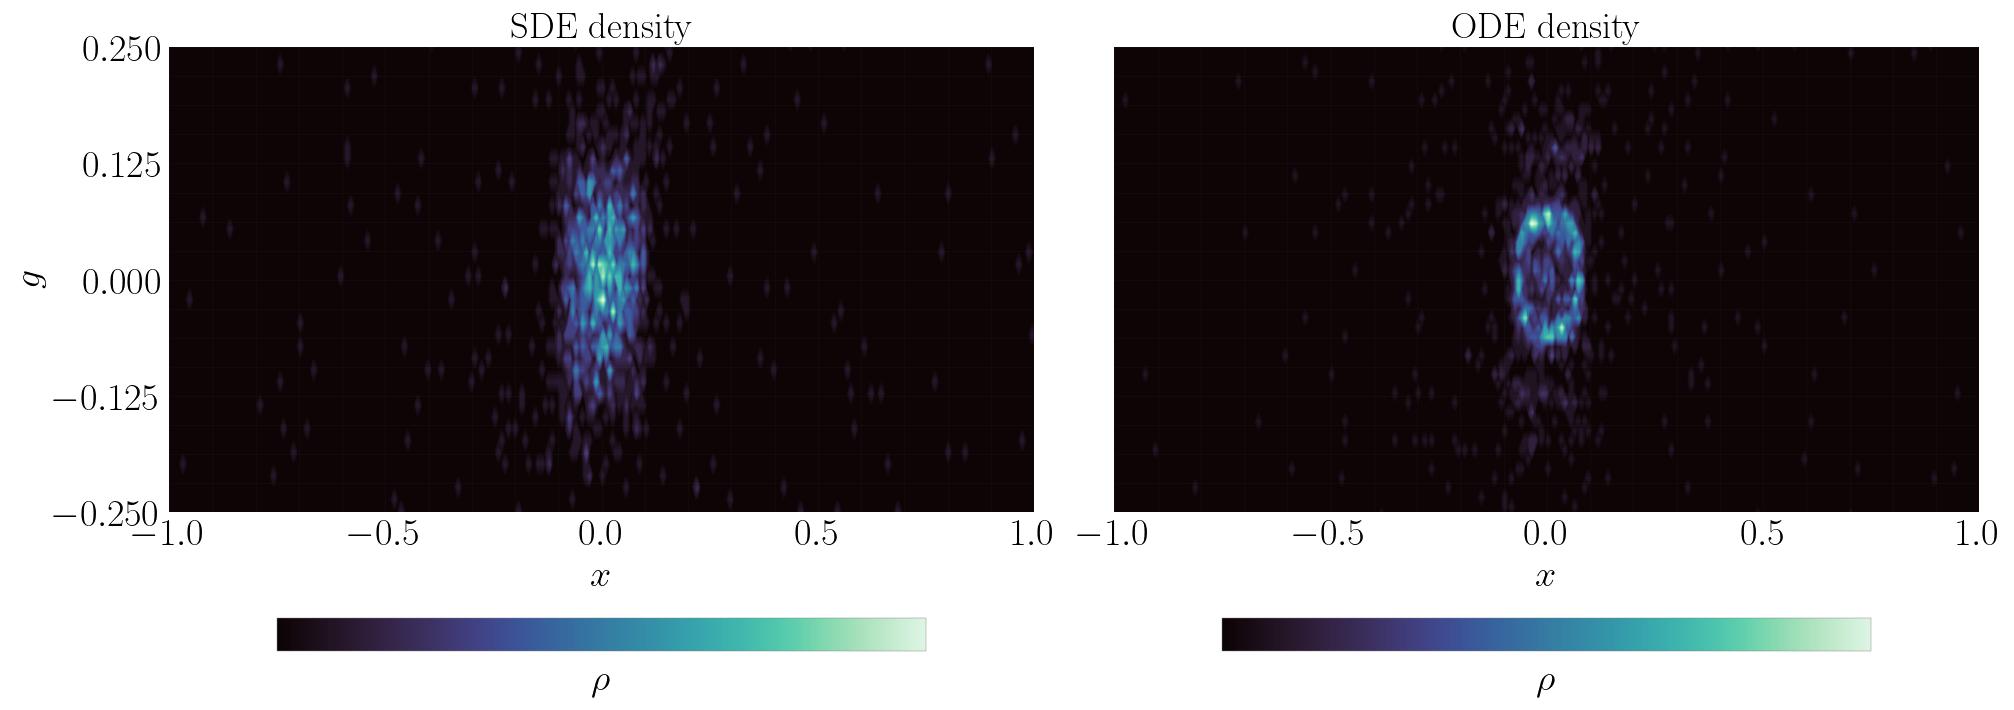

In [58]:
init_xs, init_gs = np.split(inits, 2, axis=1)

make_density_comparison_plot(
    xs=init_xs,
    gs=init_gs,
    pflow_samples=pflow_samples,
    bins=256,
    min_g=-0.25,
    max_g=0.25,
    output_name=''
    # output_name=f'{figure_output}/sde_ode_density.pdf'
)

# Statistical Histograms

## Compute quantities

In [5]:
### shamelessly copy + pasted from the histogram code
### it's efficient enough to do that in low-d :)
nbatches = 256
batch_size = cfg.ntrajs // nbatches
vxs = onp.zeros((cfg.ntrajs, 2, 1))
vgs = onp.zeros((cfg.ntrajs, 2, 1))
div_vxs = onp.zeros((cfg.ntrajs, 2))
div_vgs = onp.zeros((cfg.ntrajs, 2))


for curr_batch in range(nbatches):
    lb = batch_size*curr_batch
    ub = lb + batch_size

    (
        _,
        _,
        vxs[lb:ub],
        vgs[lb:ub],
        _,
        _,
        div_vxs[lb:ub],
        div_vgs[lb:ub],
        _,
        _
    ) = learn.map_oned_output_info(xgs[lb:ub], params)

## Make histogram

In [8]:
def make_histograms(
    div_vs: np.ndarray,
    xdots: np.ndarray,
    gdots: np.ndarray,
    cfg: np.ndarray,
    bins: int,
    output_folder: str,
    save_str: str
) -> None:
    ## make the figure
    plt.close('all')
    fw, fh     = 4, 4
    fontsize   = 22
    titles     = [r"$\dot{s}_{\text{sys}}$", r"$\dot{s}_{\text{tot}}$"]
    quantities = [div_vs, gdots]

    with sns.axes_style('whitegrid'), plt.rc_context(rc={'text.usetex': True, 'font.family': 'serif'}):
        cmap = sns.cubehelix_palette(n_colors=6)
        fig, axs = plt.subplots(nrows=1, ncols=len(titles), sharey=True, constrained_layout=True, figsize=(len(titles)*fw, fh))

        for kk, ax in enumerate(axs):
            ## make histogram
            ax.grid(which='both', axis='both', color='0.75', alpha=0.5)
            ax.tick_params(axis='both', labelsize=fontsize)
            ax.hist(quantities[kk], bins=bins, color='C0')
            ax.set_title(titles[kk], fontsize=fontsize)

            ## plot mean and std
            ax.xaxis.offsetText.set_fontsize(0.8*fontsize)
            mean, std = np.mean(quantities[kk]), np.std(quantities[kk])
            # ax.axvline(mean,     color='k',          alpha=0.25)
            # ax.axvline(mean, lw=1.0, color='k', linestyle='--')

            ## sharing y
            ax.text(0.1, 0.9, rf"$\mu={mean:.1e}$",   transform=ax.transAxes, fontsize=0.65*fontsize)
            ax.text(0.1, 0.8, rf"$\sigma={std:.1e}$", transform=ax.transAxes, fontsize=0.65*fontsize)

            ## label
            if kk == 0:
                ax.set_ylabel('count', fontsize=fontsize)
            ax.set_yscale('log')

        if save_str != '':
            fig.patch.set_facecolor('k')
            fig.patch.set_alpha(0.0)
            fig.savefig(f'{output_folder}/{save_str}.pdf', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
        else:
            # shouldn't need this, but seems that we do anyways for some reason.
            # moreover, it seems to save only a white figure if we do this outside the else block.
            plt.show()

In [ ]:
div_vs = div_vxs + div_vgs

make_histograms(
    div_vs=np.sum(div_vs, axis=1),
    xdots=np.sum(vxs**2, axis=(1, 2)),
    gdots=np.sum(vgs**2, axis=(1, 2)),
    cfg=cfg,
    bins=128,
    output_folder=figure_output,
    save_str='epr_hists'
)